In [0]:
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
#carrega dataframe de dados de treinamento já processado
df = spark.table("hive_metastore.default.processed_df_json").orderBy("account_id", "relevance")

In [0]:
#adiciona coluna com número do grupo que será usado no treinamento
group_user_id = (
    df.select("account_id").distinct()
    .withColumn("group_id", f.monotonically_increasing_id())
)

pdf_group_user_id = df.join(group_user_id, "account_id", "left").toPandas()

In [0]:
unique_groups = pdf_group_user_id["group_id"].dropna().unique()
train_groups, test_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# Dados de treino
train_df = pdf_group_user_id[pdf_group_user_id["group_id"].isin(train_groups)].copy()
train_df = train_df.sort_values("group_id").reset_index(drop=True)
group_train = train_df.groupby("group_id", sort=False).size().to_list()

# Dados de teste
test_df = pdf_group_user_id[pdf_group_user_id["group_id"].isin(test_groups)].copy()
test_df = test_df.sort_values("group_id").reset_index(drop=True)
group_test = test_df.groupby("group_id", sort=False).size().to_list()

#Features de usuário e features de ofertas
feature_cols = [
    "age", "credit_limit_category", "user_avg_amount", "user_avg_reward",
    "user_total_transactions", "days_since_registration", "is_fem",
    "user_offer_conv_rate", "engagement_score", "min_value_affordability",
    "discount_value", "min_value", "duration", "offer_type"
]

In [0]:
X_train = train_df[feature_cols]
y_train = train_df["relevance"]

X_test = test_df[feature_cols]
y_test = test_df["relevance"]

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_train.set_group(group_train)

lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
lgb_valid.set_group(group_test)

#Definição de parâmetros do modelo
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5],
    "learning_rate": 0.002,
    "random_state": 42,
    "verbosity": -1, 
    "colsample_bytree":0.7,
    "n_estimators":1500
}

#Treinamento
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 50 rounds
[10]	train's ndcg@5: 0.768039	valid's ndcg@5: 0.769659
[20]	train's ndcg@5: 0.768811	valid's ndcg@5: 0.767598
[30]	train's ndcg@5: 0.769032	valid's ndcg@5: 0.767523
[40]	train's ndcg@5: 0.769846	valid's ndcg@5: 0.769383
[50]	train's ndcg@5: 0.770258	valid's ndcg@5: 0.769849
[60]	train's ndcg@5: 0.770213	valid's ndcg@5: 0.769858
[70]	train's ndcg@5: 0.770517	valid's ndcg@5: 0.769832
[80]	train's ndcg@5: 0.770867	valid's ndcg@5: 0.769736
[90]	train's ndcg@5: 0.771049	valid's ndcg@5: 0.770225
[100]	train's ndcg@5: 0.771379	valid's ndcg@5: 0.770336
[110]	train's ndcg@5: 0.771838	valid's ndcg@5: 0.769855
[120]	train's ndcg@5: 0.772222	valid's ndcg@5: 0.770168
[130]	train's ndcg@5: 0.772499	valid's ndcg@5: 0.770258
[140]	train's ndcg@5: 0.772809	valid's ndcg@5: 0.770164
[150]	train's ndcg@5: 0.772746	valid's ndcg@5: 0.770466
[160]	train's ndcg@5: 0.773053	valid's ndcg@5: 0.770515
[170]	train's ndcg@5: 0.773251	valid's ndcg@5: 0.770

In [0]:
#calcula o ndcg@5
y_pred = model.predict(X_test)

def compute_ndcg(y_true, y_score, groups, k=5):
    ndcgs = []
    i = 0
    for size in groups:
        yt = y_true[i:i+size]
        yp = y_score[i:i+size]
        if len(yt) >= k:
            ndcgs.append(ndcg_score([yt], [yp], k=k))
        i += size
    return np.mean(ndcgs)

ndcg_at_5 = compute_ndcg(y_test.tolist(), y_pred.tolist(), group_test, k=5)
print(f"NDCG@3: {ndcg_at_5:.2f}")

NDCG@3: 0.67


In [0]:
#Feature importance
feature_importance = model.feature_importance(importance_type='gain')

feature_names = X_train.columns.tolist()

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print(feat_imp_df)

                    feature   importance
0           user_avg_reward  1829.710127
1      user_offer_conv_rate   609.354052
2            discount_value   295.870473
3   min_value_affordability   149.594510
4                 min_value   107.016323
5           user_avg_amount   103.802399
6   days_since_registration    67.524760
7          engagement_score    57.111229
8   user_total_transactions    53.133621
9                       age    53.008431
10                 duration    21.589270
11    credit_limit_category    17.044190
12                   is_fem     1.414300
13               offer_type     0.000000


<Figure size 1440x432 with 0 Axes>

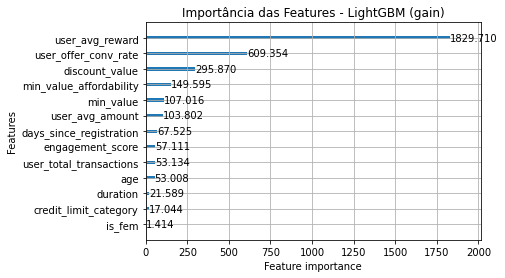

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Importância das Features - LightGBM (gain)")
plt.show()


In [0]:
#Criando a recomendação 

user_features_cols = [
    "age", "credit_limit_category", "user_avg_amount", "user_avg_reward",
    "user_total_transactions", "days_since_registration", "is_fem",
    "user_offer_conv_rate", "engagement_score", "min_value_affordability",
]

item_features_cols = [
    "discount_value", "min_value", "duration", "offer_type"
]

user_df = df_filtered[["account_id"] + user_features_cols].drop_duplicates()
offer_df = df_filtered[["offer_id"] + item_features_cols].drop_duplicates()

user_df = user_df.dropna()
offer_df = offer_df.dropna()

pred_df = user_df.merge(offer_df, how="cross")

# As mesmas features usadas no modelo
feature_cols = user_features_cols + item_features_cols
X_pred = pred_df[feature_cols]

# Predição com modelo treinado
pred_df["score"] = model.predict(X_pred)

top5_df = (
    pred_df.sort_values(["account_id", "score"], ascending=[True, False])
    .groupby("account_id")
    .head(5)
)

top5_recommendations = top5_df[["account_id", "offer_id", "score"]]
top5_recommendations.head(16)

,account_id,offer_id,score
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.061862
6,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,0.059572
8,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.054565
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.054431
2,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.053222
14,0009655768c64bdeb2e877511632db8f,2298d6c36e964ae4a3e7e9706d1fb8c2,0.052275
9,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.047135
10,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.045926
37967,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.060587
37975,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.060587
